# トランザクション分類のためのクラスタリング

このノートブックでは、データがラベル付けされていないが、それらを意味のあるカテゴリにクラスタリングするために使用できる特徴量がある場合のユースケースを扱っています。クラスタリングの課題は、それらのクラスターを際立たせる特徴量を人間が読み取れる形にすることです。その点で、GPT-3を用いてクラスタの説明を生成する方法を探ります。これにより、以前はラベルのないデータセットにラベルを適用できます。

モデルにデータを供給するためには、[Multiclass classification for transactions Notebook](Multiclass_classification_for_transactions.ipynb)で示されているアプローチを用いて作成されたエンベディングを使用します。このエンベディングは、データセット内の全359件のトランザクションに適用され、学習におけるより大きなプールを提供します。

## Setup

In [18]:
# imports
import openai
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import os
from ast import literal_eval
import japanize_matplotlib

openai.api_key = os.getenv("OPENAI_API_KEY")
COMPLETIONS_MODEL = "text-davinci-003"

# This path leads to a file with data and precomputed embeddings
embedding_path = "data/library_transactions_with_embeddings_359.csv"


## クラスタリング

以前に作成した特徴量埋め込みを用いて、[クラスタリングのノートブック](Clustering.ipynb)で取り上げた手法を再利用します。K-平均法（K-Means）を用いてデータセットをクラスタリングします。その後、Completionsエンドポイントを用いて、各クラスタに対する説明を生成し、その効果を評価します。

この手法を採用することで、データセット内の関連性のあるグループを識別し、それに基づいて分析や予測を行うことができます。

In [13]:
df = pd.read_csv(embedding_path)

In [14]:
embedding_df = pd.read_csv(embedding_path)
embedding_df["embedding"] = embedding_df.embedding.apply(literal_eval).apply(np.array)
matrix = np.vstack(embedding_df.embedding.values)
matrix.shape

(359, 1536)

In [15]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
embedding_df["Cluster"] = labels

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 't-SNEを使用して言語2Dで可視化されたクラスター')

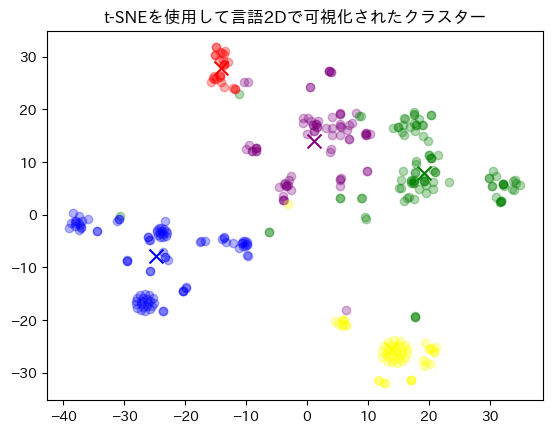

In [16]:
tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow"]):
    xs = np.array(x)[embedding_df.Cluster == category]
    ys = np.array(y)[embedding_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("t-SNEを使用して言語2Dで可視化されたクラスター")


In [19]:
# We'll read 10 transactions per cluster as we're expecting some variation
transactions_per_cluster = 10

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    transactions = "\n".join(
        embedding_df[embedding_df.Cluster == i]
        .combined.str.replace("Supplier: ", "")
        .str.replace("Description: ", ":  ")
        .str.replace("Value: ", ":  ")
        .sample(transactions_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        model=COMPLETIONS_MODEL,
        # モデルに求める説明の種類についての指示をプロンプトに含めます。
        # これらの取引を意味のあるクラスタにまとめて、最もお金を使っているエリアに焦点を当てたいと考えています。
        # 次の取引には共通するテーマ性がありますか？\n\n取引:\n"""\n{transactions}\n"""\n\nテーマ:
        # prompt=f'''We want to group these transactions into meaningful clusters so we can target the areas we are spending the most money. 
        #         What do the following transactions have in common?\n\nTransactions:\n"""\n{transactions}\n"""\n\nTheme:''',
        prompt=f'''これらの取引を意味のあるクラスタにまとめて、最もお金を使っているエリアに焦点を当てたいと考えています。
        次の取引には共通するテーマ性がありますか？\n\n取引:\n"""\n{transactions}\n"""\n\nテーマ:''',
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = embedding_df[embedding_df.Cluster == i].sample(transactions_per_cluster, random_state=42)
    for j in range(transactions_per_cluster):
        print(sample_cluster_rows.Supplier.values[j], end=", ")
        print(sample_cluster_rows.Description.values[j], end="\n   ")
        #print(str(sample_cluster_rows.Value).values[j])

    print("-" * 100)


Cluster 0 Theme:  電力、費用、IT機器、コンピュータ機器、購入
EDF ENERGY, Electricity Oct 2019 3 buildings
   City Of Edinburgh Council, Non Domestic Rates 
   EDF, Electricity
   EX LIBRIS, IT equipment
   City Of Edinburgh Council, Non Domestic Rates 
   CITY OF EDINBURGH COUNCIL, Rates for 33 Salisbury Place
   EDF Energy, Electricity
   XMA Scotland Ltd, IT equipment
   Computer Centre UK Ltd, Computer equipment
   ARNOLD CLARK, Purchase of an electric van
   ----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  これらの取引は、学術研究、文化保存、建築、法律、文学、アーカイブ、オンライン/印刷サブスクリプションなど、さまざまな分野に関連しています。
Institute of Conservation, This payment covers 2 invoices for student bursary costs
   PRIVATE SALE, Collection of papers of an individual
   LEE BOYD LIMITED, Architectural Works
   ALDL, Legal Deposit Services
   RICK GEKOSKI, Papers 1970's to 2019 Alisdair Gray
   ADAM MATTHEW DIGITAL LTD, Resource -  slavery abolution and social justice
   PROQUEST INFORMATI

### Conclusion

We now have five new clusters that we can use to describe our data. Looking at the visualisation some of our clusters have some overlap and we'll need some tuning to get to the right place, but already we can see that GPT-3 has made some effective inferences. In particular, it picked up that items including legal deposits were related to literature archival, which is true but the model was given no clues on. Very cool, and with some tuning we can create a base set of clusters that we can then use with a multiclass classifier to generalise to other transactional datasets we might use.